# Scripts for analysis of methylome at population level

## Preamble

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import csv
from itertools import izip
import statsmodels.api as sm
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
import brewer2mpl
#from scipy.misc import comb

In [2]:
#font = {'family' : 'sans',
#        'weight' : 'bold',
#        'size'   : 16}
#matplotlib.rc('font', **font)

# use pandas matplotlib stylesheet for nicer plots
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)

# use colorbrewer colors

import brewer2mpl
bmap = brewer2mpl.get_map('Set2','qualitative', 7)
matplotlib.rcParams['axes.color_cycle'] = bmap.mpl_colors

## Functions for methylation level inference

In [167]:
def likelihood_methbias(p, M, N):
    #a = np.exp(M*np.log(p) + (N - M)*np.log(1 - p))
    b = p**M*(1 - p)**(N - M)
    return b

def plot_methbias(sample, meth_input='levels'):
    alpha = .3
    color = 'k'
    support = np.linspace(0, 1, 100)
    for s in sample:
        if meth_input == 'levels':
            met_calls = round(s[0]*s[1])
        elif meth_input == 'calls':
            met_calls = float(s[0])
        all_calls = float(s[1])
        assert all_calls >= met_calls
        assert all_calls > 0.
        y = likelihood_methbias(support, met_calls, all_calls) # assuming uniform prior
        y_ceil = y/y.max()
        plt.plot(support, y_ceil, color, alpha=alpha)
        plt.plot(met_calls/all_calls, 1.1, color + 'o', alpha=alpha)
    plt.box('on')
    plt.grid('on', axis='x')
    plt.tick_params(left='off', right='off', top='on', bottom='off', labelleft='off')

def entropy(distribution):
    if type(distribution) is not np.ndarray:
        distribution = np.array(distribution)
    assert abs(distribution.sum() - 1) < 1e-10
    terms = distribution*np.log(distribution[distribution != 0.])
    return -terms.sum()

def js_divergence(distributions, weights):
    """Based on discrete probability distributions and frequencies rather than probability estimates"""
    if weights.shape[0] != distributions.shape[1]:
        distributions = distributions.T
    w_dist = weights*distributions
    #print w_dist.sum(1)
    H_mix = entropy(w_dist.sum(1))
    H_sum = sum(weights*np.array(map(entropy, distributions.T)))
    return H_mix*(1 - H_sum/H_mix)

def diversity(sample, meth_input='levels'):
    sample = np.array(sample)
    mean_meth, mean_cov = np.mean(sample, axis=0)
    result = {
              'sample_size': len(sample),
              'mean_methylation_level': round(mean_meth, 2),
              'mean_coverage': round(mean_cov, 2)
              }
    distributions = np.zeros((len(sample[0]), len(sample)))
    weights_unnormalized = np.zeros((len(sample),))
    for i, s in enumerate(sample):
        coverage = float(s[1])
        assert coverage > 0.
        if meth_input == 'calls':
            met_calls = float(s[0])
            assert met_calls == 0. or met_calls >= 1.
            assert coverage >= met_calls
            distributions[:, i] = [met_calls/coverage, (coverage - met_calls)/coverage]
        elif meth_input == 'levels':
            met_level = float(s[0])
            assert 0. <= met_level <= 1.
            distributions[:, i] = [met_level, 1. - met_level]
        weights_unnormalized[i] = 1.
        #weights_unnormalized[i] = coverage
        #weights_unnormalized[i] = np.sqrt(coverage)
        #weights_unnormalized[i] = np.log(coverage)
    weights = weights_unnormalized/weights_unnormalized.sum()
    result['diversity'] = round(np.exp(js_divergence(distributions, weights)), 2)
    return result

In [30]:
# example.png
sample = [(.0, 20), (.0, 8), (.0,15), (.0, 8), (.0,15), (.0, 9)]
#plot_methbias(sample)
print(diversity(sample))

{'sample_size': 6, 'mean_methylation_level': 0.0, 'diversity': 1.0, 'mean_coverage': 12.5}


## Methbase

The following cell is for converting binary files from methbase.

In [13]:
import os

# change data dir
os.chdir(os.environ['HOME'] + '/project_PopulationEpigenetics/project/data/2009jacob/methpipe/methbase')

os_name = os.uname()[0]
bigwig_files = !ls *.bw
chromosomes = ['chr' + str(num) for num in range(1, 6)]

for chrom in chromosomes:
    for infile in bigwig_files:
        outfile = infile.split('/')[-1].replace('.all.', '.' + chrom + '.').replace('.bw', '.bedg')
        # convert binary files using UCSC tools
        !../../../../bin/{os_name}/bigWigToBedGraph -chrom={chrom} {infile} {outfile}

Combine reads and methylation levels.

In [ ]:
for chrom in chromosomes[1:]:
    !sort --merge --key=2,2n --key=3,3n {target_path}*Line[0-9*]*{chrom}* | bedtools merge -nms > {target_path + 'Arabidopsis_MA-LineAll.' + chrom + '.meth.merged.bedg'}
    #!unionBedGraphs -i {target_path + '*' + chrom + '*'} -header -names {} >> {target_path + 'test.bedg'}

## Calculating the single nucleotide population diversity 

The methylation tables for Schmitz et al. 2013 as produced by methpipe are linked in the following folder:

In [3]:
cd /home/oender/data/2013schmitz/SRP018263/methylomes/

/home/oender/data/2013schmitz/SRP018263/methylomes


We produce three files from the methylation tables accross the whole population: methLevel.csv and coverage.csv concatenate the methylation_level and coverage columns for all samples, respectively. Additionaly, we produce a file with chromosome, start position and context from any single file since they should be the same for all samples (due to mapping to the same reference genome).

In [ ]:
# we concatenate only the symbolic links (i.e. no replicates)
files = !find ./ -type l

methLevel_field = '5'
coverage_field = '6'

fields_methLevel = [' '.join(['<(cut -f', methLevel_field, s + ')']) for s in files]
fields_coverage = [' '.join(['<(cut -f', coverage_field, s + ')']) for s in files]

inputs_methLevel = ' '.join(fields_methLevel)
inputs_coverage = ' '.join(fields_coverage)

# following calls give syntax error, but copying the command with the inputs string to the shell works!
#!paste {inputs_methLevel} > methLevel.csv
#!paste {inputs_coverage} > coverage.csv

#!cut -f 1,2,4 SRX248613 > position_context.csv

In [103]:
sample_threshold = 19
coverage_threshold = 0

# first open a csv.reader() instance for the above three files
with open('position_context.csv', 'rb') as p, open('methLevel.csv', 'rb') as m, open('coverage.csv', 'rb')as c:
    pos_lines = csv.reader(p, delimiter='\t')
    met_lines = csv.reader(m, delimiter='\t')
    cov_lines = csv.reader(c, delimiter='\t')
    # open the file to write results in
    with open('population_summary.bed', 'wb') as bedfile:
        # define headerline of bedfile 
        header = ['chrom', 'start', 'end', 'context',
                  'diversity', 'mean_methylation_level', 'mean_coverage', 'sample_size']
        # we make a csv.DictWriter instance since our diversity function also returns a dict,
        # that is we make a dict for each line that is written into the file. the csv.DictWriter
        # takes care that the value is written into the correct column according to the header
        bedwriter = csv.DictWriter(bedfile, header, delimiter='\t')
        bedwriter.writeheader()
        # write the lines using zipped iterators
        for pos, met, cov in izip(pos_lines, met_lines, cov_lines):
            samples = zip(map(float, met), map(int, cov))
            # we make a list of tuples where only samples are included that cover the site
            covered_samples = [s for s in samples if s[1] > coverage_threshold]
            sample_size = len(covered_samples)
            if sample_size > sample_threshold:
                #print pos, diversity(covered_samples)
                # the diversity function returns a dictionary like so:
                # {'sample_size': 6, 'mean_methylation_level': 0.5, 'diversity': 2.0, 'mean_coverage': 12.5}
                # the missing key-value pairs are added according to the header from the position_context.csv
                datadict = diversity(covered_samples)
                datadict['chrom'] = 'Chr' + str(pos[0])
                datadict['start'] = pos[1]
                datadict['end'] = int(pos[1]) + len(pos[2])
                datadict['context'] = pos[2]
                bedwriter.writerow(datadict)
                #break

## Analysis of the population summary file and figures

In [4]:
cd /home/oender/data/2013schmitz/SRP018263/methylomes/

/home/oender/data/2013schmitz/SRP018263/methylomes


In [4]:
dfpop = pd.read_csv('population_summary.bed', delimiter='\t', header=0, na_values='nan')

#### Some data transformations that should be unnecessary later on

NaN fix

In [11]:
dfpop.fillna(1.0, inplace=True) # FIXME: this is a hack just because I know that the nan's are nondiverse sites (diversity=1.0)
if pd.isnull(dfpop).any(1).nonzero()[0] == np.array([]): # test that no NaNs are left
    dfpop.to_csv('population_summary.nanfix.bed', sep='\t', header=True, index=False)

### Empirical CDF to see the distribution of diversity scores accross the genome

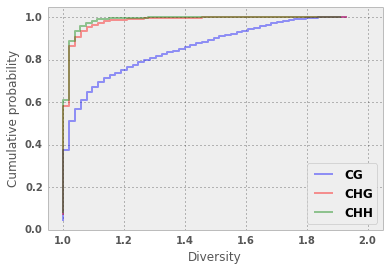

In [354]:
contexts = ['CG', 'CHG', 'CHH']
chrom = range(1,6)
colors1 = 'brg'
colors2 = 'brgkm'
for col, group in zip(colors1, contexts):
    div_values = dfpop[(dfpop['context']==group) & (dfpop.sample_size == 140)]['diversity']
    div_ecdf = sm.distributions.ECDF(div_values)
    x = np.linspace(min(div_values), max(div_values))
    y = div_ecdf(x)
    plt.step(x, y, color=col, alpha=0.4, linewidth=2, label=group)

plt.legend(loc='lower right')
plt.grid('on', axis='both')
plt.axis([0.95, 2.05, 0, 1.05])
plt.xlabel('Diversity')
plt.ylabel('Cumulative probability')

### The relation between mean methylation level and diversity

context
CG         Axes(0.125,0.125;0.775x0.775)
CHG        Axes(0.125,0.125;0.775x0.775)
CHH        Axes(0.125,0.125;0.775x0.775)
dtype: object

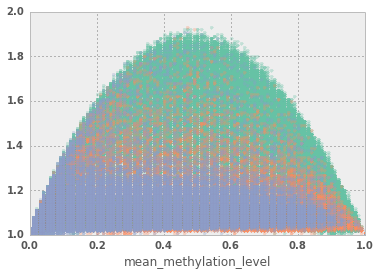

In [353]:
dfpop[dfpop.sample_size > 139].groupby(['context']).plot(x='mean_methylation_level', y='diversity',style='.', alpha=0.3)

### methylome diversity for different contexts 

KeyError: '#chrom'

/home/oender/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


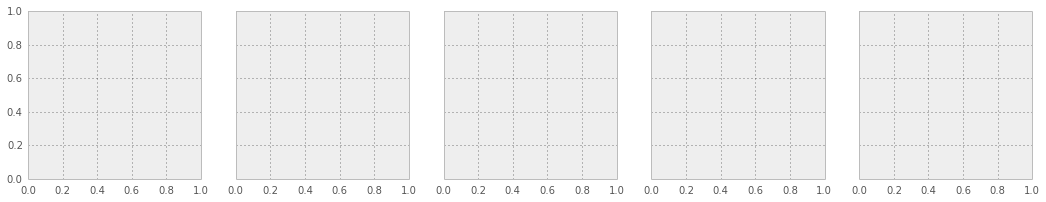

In [20]:
df_covered = dfpop.query('sample_size > 39')
chroms = range(1,6)
fig, axs = plt.subplots(1, len(chroms), sharey=True, figsize=(18,3))
for chrom in chroms:
    df = df_covered[(df_covered['chrom']==chrom)]
    for key, group in df.groupby(['context']):
        axs[chrom-1].plot(group['start'], group['diversity'], '.', label=key, alpha=0.3)
        plt.legend(loc='upper right', numpoints=1, framealpha=0.9)
#fig.legend()
#plt.show()
#dfpop[(dfpop['#chrom']==1) & (dfpop.sample_size > 39)].query('start > 3042 & end < 4053').hist('diversity')

### Diversity scores in genomic features

In [6]:
cd /home/oender/data/2013schmitz/diversity/

/home/oender/data/2013schmitz/diversity


First, we make context-specific bedgraph files

In [9]:
dfpop = pd.read_csv('diversity.weighted.bed', sep='\t', names=['chrom', 'start', 'end', 'context', 'diversity'])

In [10]:
columns = ['chrom', 'start', 'end', 'diversity']
for key, group in dfpop.groupby('context'):
    group.to_csv('div.%s.bed' % key, sep='\t', header=False, index=False)

The files div.{CG|CHG|CHH}.bed ar mapped onto conserved noncoding sequences (cns) and genome features (gff) with bedtools like so

    bedtools map -a AT_CNS.sorted.bed -b div.CHG.bed -c 4 -o mean | cut -f 1,2,3,4,9 > div.CHG.cns.bed
    bedtools map -a tair10.sorted.gff -b div.CHH.bed -c 4 -o mean | awk -v OFS="\t" -F"\t" '{print $1, $4, $5, $3, $10}'> div.CHH.gff.bed

In [124]:
div_CG_CNS = pd.read_csv('div.CG.cns.bed',
                         na_values='.',
                         sep='\t',
                         header=None,
                         names=['chrom', 'start', 'end', 'genome feature','mean CG diversity'])

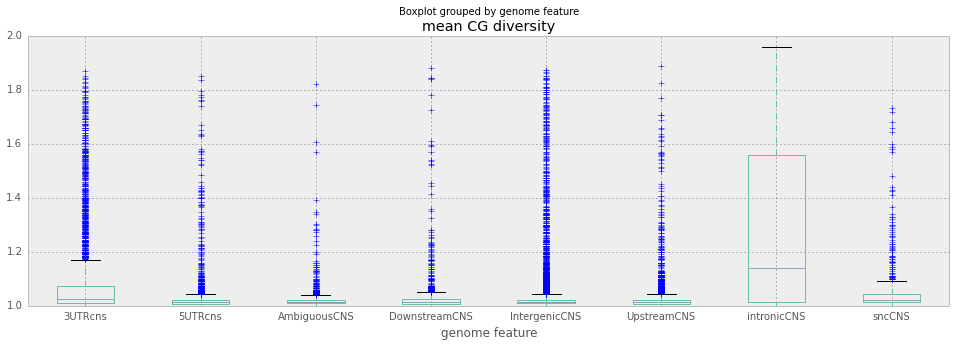

In [125]:
div_CG_CNS.boxplot('mean CG diversity', by='genome feature', figsize=(16,5))

In [126]:
div_CHG_CNS = pd.read_csv('div.CHG.cns.bed', na_values='.', sep='\t', header=None, names=['chrom', 'start', 'end', 'genome feature','mean CHG diversity'])

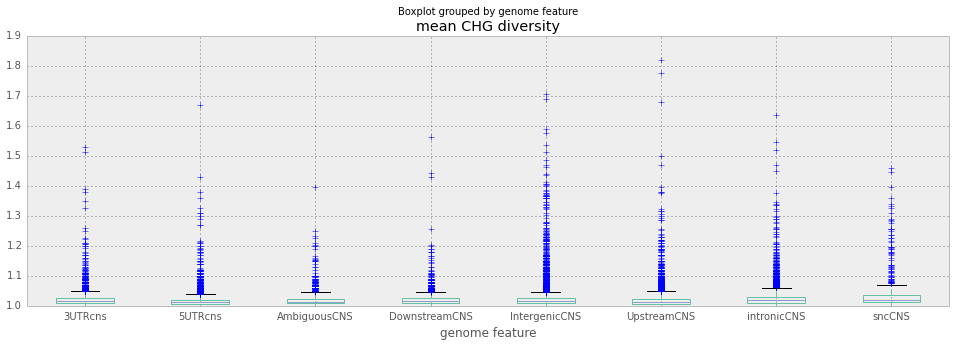

In [127]:
div_CHG_CNS.boxplot('mean CHG diversity', by='genome feature', figsize=(16,5))

In [128]:
div_CHH_CNS = pd.read_csv('div.CHH.cns.bed', na_values='.', sep='\t', header=None, names=['chrom', 'start', 'end', 'genome feature','mean CHH diversity'])

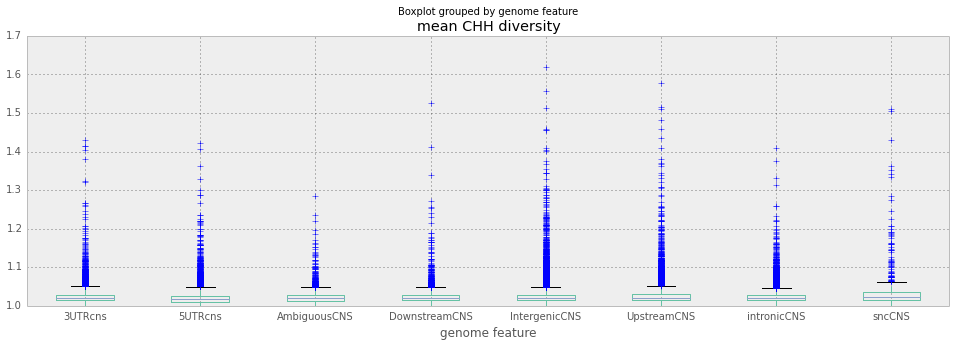

In [129]:
div_CHH_CNS.boxplot('mean CHH diversity', by='genome feature', figsize=(16,5))

In [145]:
div_CG_GFF = pd.read_csv('div.CG.gff.bed',
                         na_values='.',
                         sep='\t',
                         header=None,
                         names=['chrom', 'start', 'end', 'genome feature','mean CG diversity'])

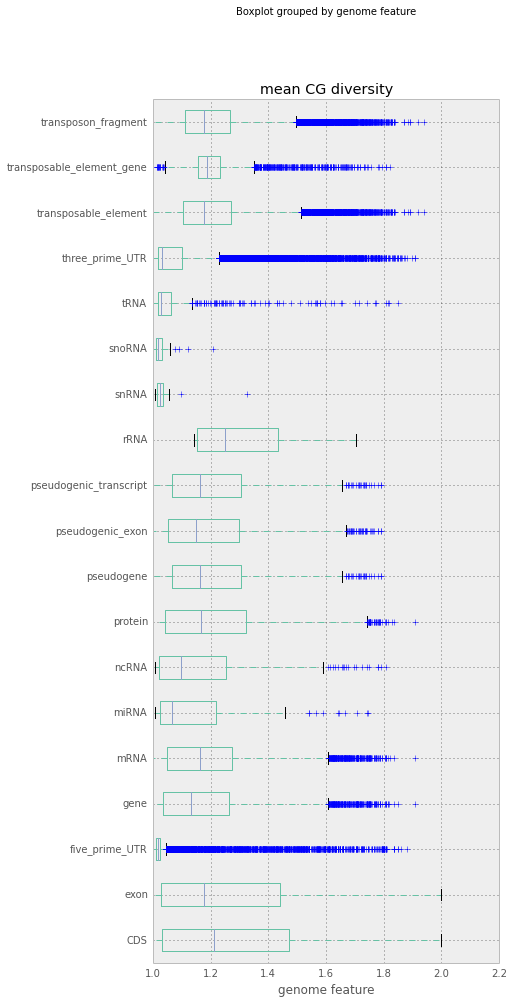

In [150]:
#fig, ax = plt.subplots()
div_CG_GFF.boxplot('mean CG diversity', by='genome feature', figsize=(6,16), vert=False)
#ax.set_xticklabels(div_CG_GFF['genome feature'], rotation=40)

In [151]:
div_CHG_GFF = pd.read_csv('div.CHG.gff.bed',
                         na_values='.',
                         sep='\t',
                         header=None,
                         names=['chrom', 'start', 'end', 'genome feature','mean CHG diversity'])

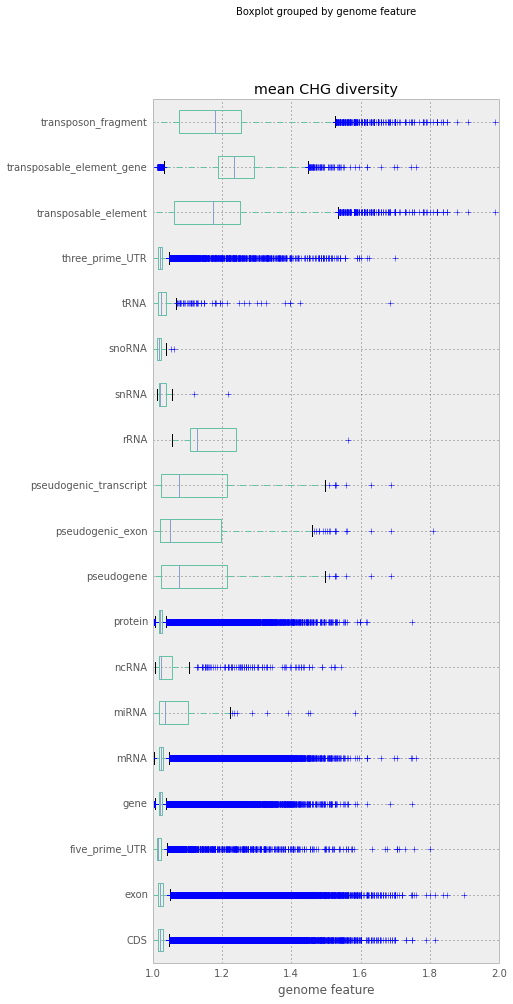

In [153]:
div_CHG_GFF.boxplot('mean CHG diversity', by='genome feature', figsize=(6,16), vert=False)

In [154]:
div_CHH_GFF = pd.read_csv('div.CHH.gff.bed',
                         na_values='.',
                         sep='\t',
                         header=None,
                         names=['chrom', 'start', 'end', 'genome feature','mean CHH diversity'])

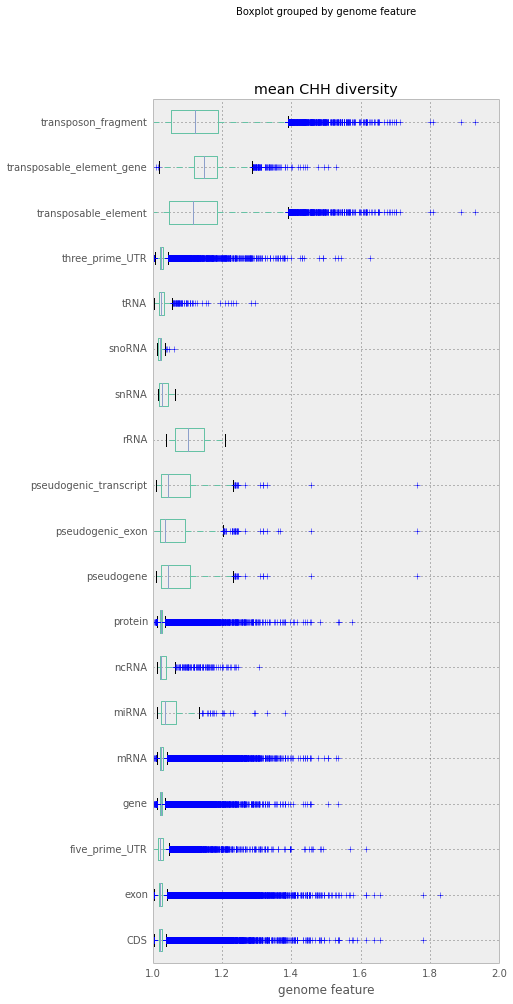

In [155]:
div_CHH_GFF.boxplot('mean CHH diversity', by='genome feature', figsize=(6,16), vert=False)